In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import colorcet
import matplotlib.patches as patches
from mayavi import mlab
import mne
import nibabel
import matplotlib.colors as mcolors
from PIL import Image

import os.path as op
import nibabel as nib
from colorsys import rgb_to_hls, hls_to_rgb
from matplotlib.colors import ListedColormap
from colorcet import cm

mlab.init_notebook('png')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ModuleNotFoundError: No module named 'mayavi'

In [2]:
cmap = plt.get_cmap('tab10')
b, g, r = cmap(np.linspace(0, 1, 10))[[0, 2, 3]][:, :3]
x = np.linspace(0, 1, 256)[:, None]
w = np.ones(3)

kb = ListedColormap(x * b + (1-x) * w)
kg = ListedColormap(x * g + (1-x) * w)
kr = ListedColormap(x * r + (1-x) * w)
grays = ListedColormap(np.clip((1-x)*w, .3, 1.))

In [3]:
cmap = plt.get_cmap('Paired')
four_colors = cmap([.0, .15, .35, .45])
cmap = plt.get_cmap('seismic')
four_colors = cmap([.05, .3, .7, .95])

four_cmap = mcolors.LinearSegmentedColormap.from_list('four_colors', four_colors, N=4)

In [4]:
def plot_transformer(ax, n_steps=3, n_layers=3, n_dims=4):
    values = plot_architecture(ax, n_layers, n_dims, n_steps, cmap=[kg, kr, kr], grey_context=True)

    layer = 0
    step = 2
    ax.matshow(values[step-1, -1],
               cmap=kg,
               extent=[layer-.3, layer+.3, step-.3, step+.3])
    rect = patches.Rectangle((layer-.3,step-.33),.6,.63,linewidth=1,
                             edgecolor='k',facecolor='none')
    ax.add_patch(rect)

    opts = dict(verticalalignment='center', fontsize=15)
    for i, word in enumerate('dogs chase cats'.split()):
        ax.text(-1., i, word, horizontalalignment='center', color='k', **opts)
        # ax.add_patch(patches.FancyBboxPatch(
        #     [-1.5, i-0.2], 1., 0.4,
        #     color='lightgray',
        #     boxstyle=patches.BoxStyle("Round", pad=0.1)))

    for i, word in enumerate(['are', 'cats', 'daily']):
        ax.text(n_layers-.5, i, word, horizontalalignment='left', color='k', **opts)
    opts['horizontalalignment'] = 'right'
    opts['fontsize'] = 15
    ax.text(n_layers+.75, 0, '✘', color='k', **opts)
    ax.text(n_layers+.75, 1, '✓', color='k', **opts)
    ax.text(n_layers+.75, 2, '✓', color='k', **opts)

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.axis('off')
    ax.set_ylim(-.5, n_layers-.5)
    ax.set_xlim(-2, n_steps+1)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.invert_yaxis()

In [5]:
def plot_bottleneck(ax, n_layers=3, n_dims=4, n_steps=2, multi_input=False, multi_output=True, cmap=four_cmap):
    arrow = dict(width=.01, head_width=.1, color='gray', zorder=-1)
    
    if not isinstance(cmap, (list, tuple)):
        cmap = [cmap]*n_layers
        
    # current
    mid_layer = n_layers // 2
    for step in range(n_steps-1):
        if step == 0 and multi_input:
            continue
        ax.arrow(step, mid_layer, .4, 0, **arrow)

    # input
    if multi_input:
        for layer in range(-n_layers//2+1, n_layers//2+1):
            ax.arrow(-1., mid_layer-layer, 
                     .5, .8* layer, **arrow)
    # output
    if multi_output:
        for layer in range(-n_layers//2+1, n_layers//2+1):
            ax.arrow(n_steps-2., mid_layer, 
                     .45, .8* layer, **arrow)
    
    
    # activations
    all_values = np.random.rand(n_steps, n_layers, n_dims, n_dims)
    for layer in range(n_layers):
        for step in range(n_steps):
            if step != n_steps//2 and layer != (n_layers-1):
                continue

            ax.matshow(all_values[step, layer],
                       cmap=cmap[layer],
                       extent=[layer-.3, layer+.3, step-.3, step+.3])
            rect = patches.Rectangle((layer-.3, step-.33),.6,.63, 
                                     linewidth=1, edgecolor='k',
                                     facecolor='none')
            ax.add_patch(rect)

    return all_values

In [6]:
def plot_wordemb(ax):
    n_layers = 3
    n_steps = 3
    n_dims = 4
    
    plot_bottleneck(ax, n_layers=n_layers, multi_input=False, n_steps=n_steps, n_dims=n_dims, cmap=(grays, kg, grays));

    opts = dict(verticalalignment='center', fontsize=15)
    ax.text(-1., 1, 'cats', horizontalalignment='center', color='k', **opts)

    for i, word in enumerate(['dogs', 'mice', 'rain']):
        ax.text(n_layers-.5, i, word, horizontalalignment='left', color='k', **opts)
    opts['horizontalalignment'] = 'right'
    opts['fontsize'] = 15
    ax.text(n_layers+.75, 2, '✘', color='k', **opts)
    ax.text(n_layers+.75, 1, '✓', color='k', **opts)
    ax.text(n_layers+.75, 0, '✓', color='k', **opts)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1, 3)

    ax.axis('off')
    ax.set_ylim(-.5, 2.5)
    ax.set_xlim(-2, 4)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.invert_yaxis()

In [7]:
def pixelated():
    fig, ax = plt.subplots(1, figsize=[8, 4])
    ax.text(0, 0, 'cats', fontsize=200, horizontalalignment='center', verticalalignment='center')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis('off')

    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = data[::19, ::19][3:-4, 5:-4]
    fig.clear()
    
    fig, ax = plt.subplots(1, figsize=[8, 4])
    ax.imshow(img)
    for x in range(len(img)):
        ax.axhline(x+.5, color='k', lw=.5)
    for x in range(len(img[0])):
        ax.axvline(x+.5, color='k', lw=.5)
    ax.axis('off')

    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    fig.clear()
    return data[50:235, 70:520]

In [8]:
def make_brain_img_pixelated(decim=1):
    import plot_brain
    subjects_dir = plot_brain.__path__[0] + '/data/'
    subject = 'fsaverage'
    hemi = 'lh'
    surface = 'inflated_pre'
    fname = subjects_dir + '/%s/surf/%s.%s' % (subject, hemi, surface)
    rr, tris = nibabel.freesurfer.read_geometry(fname)

    np.random.seed(8)
    rr -= rr.min(0)
    rr /= rr.max(0)
    vertices = np.random.randint(0, len(rr), 3)
    data = np.zeros(len(rr))
    coef = 2
    for idx in vertices:
        data += 1/((rr[:, 0] - rr[idx, 0])**coef + 
                   (rr[:, 1] - rr[idx, 1])**coef + 
                   (rr[:, 2] - rr[idx, 2])**coef + .1)
    data /= np.nanmax(np.abs(data))
    data -= np.nanmean(data)
    
    sel = list(range(len(data))[::decim])
    stc = mne.SourceEstimate(data[sel], 
                             [sel, []], 0, 1, subject)



    imgs = list()
    for cortex in ('classic', 'k'):
        mlab_fig = mlab.figure(size=[800, 600])

        brain = stc.plot(
            hemi=hemi,
            views='lat',
            colormap=four_cmap,
            subjects_dir=subjects_dir,
            surface=surface, 
            clim=dict(kind='value', pos_lims=[.2, .3, .4] if cortex=='k' else [1, 2, 3]),
            backend='mayavi',
            spacing='all',
            background='w',
            colorbar=False,
            figure=mlab_fig,
            verbose=False,
            cortex=cortex,
        )

        img = mlab.screenshot(figure=mlab_fig, mode='rgba', antialiased=True)
        img = img[110:500, 120:680] # crop white


        fig, ax = plt.subplots(1, figsize=[14, 10])
        if cortex == 'k':
            img = img[::25, ::25]
            shape = img.shape
            img = img.reshape(-1, 4)
            mask = np.where((img[:, :3].sum(1)>0)&(img[:, 3]==1))[0]

            idx = np.random.randint(0, len(four_colors), len(mask))
            colors = four_colors[idx]
            img[mask, :] = colors
            img = img.reshape(shape)
        ax.imshow(img)
        ax.axis('off')

        fig.canvas.draw()
        img_data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img_data = img_data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        fig.clear()
        imgs.append(img_data)

    data = imgs[1] / 255.
    mask = (data.mean(-1) < 1.) * (data.mean(-1) >.1)

    img = (imgs[1]/255. * mask[..., None] + 
           imgs[0]/255. * (1-mask[..., None]))
    return img[70:-70, 70:-70]

In [9]:
def plot_brain(ax):
    img = make_brain_img_pixelated()
    ax.imshow(img.transpose(1, 0, 2)[:, ::-1], extent=[0., .6, 0., .8])
    ax.add_patch(patches.Circle([.17-.1, .05+.56], 0.05, lw=1, edgecolor='k', facecolor='w'))
    ax.add_patch(patches.Ellipse([.165-.1, .09+.56], .01, .05, angle=90, color='k'))
    ax.axis('off')
    # opts = dict(verticalalignment='center', fontsize=15,
    #             horizontalalignment='center', color='k')
    # for i, word in enumerate('not really happy'.split()):
    #     ax.text(-.14, (2-i)/6+.03, word,  **opts)
    #     ax.add_patch(patches.FancyBboxPatch(
    #         [-.22, (2-i)/6], .16, 0.06,
    #         color='lightgray',
    #         boxstyle=patches.BoxStyle("Round", pad=0.02)))
    
    opts = dict(verticalalignment='center', fontsize=14)
    inputs = 'not really happy'.split()
    for i, word in enumerate(inputs):
        ax.text(-.14, (2-i)/4.+.15, word, horizontalalignment='center', color='k', **opts, 
                rotation=-90)
        # ax.add_patch(patches.FancyBboxPatch(
        #     [-.15, (2-i)/2], .07, 0.12,
        #     color='lightgray',
        #     boxstyle=patches.BoxStyle("Round", pad=0.01)))
    
    ax.set_aspect('equal')
    ax.set_ylim(-.26, .9)
    ax.set_xlim(-.05, .62)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ccaucheteux/opt/anaconda3/envs/mous_shallow_nlm/lib/python3.7/site-packages/plot_brain/data//fsaverage/surf/lh.inflated_pre'

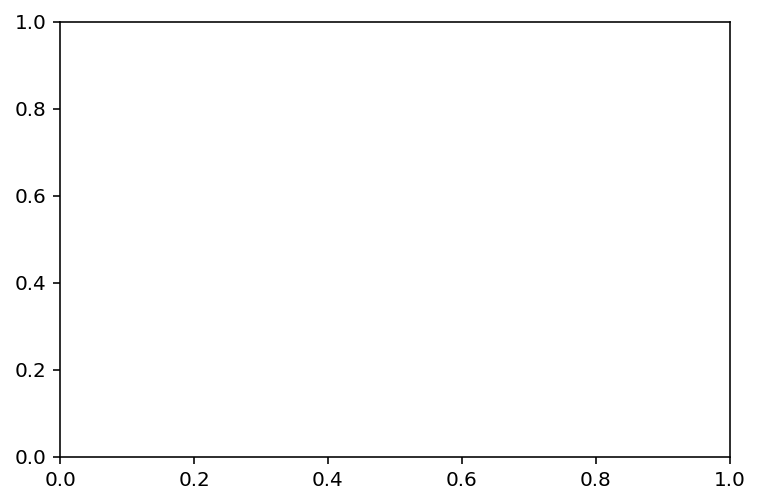

In [10]:
plot_brain(plt.gca())

In [37]:
def plot_activations(ax, n_layers=7, n_dims=4, n_steps=1, cmap=four_cmap, grey_context=False, future=False, n_heads=-1, grey_but=None):
    arrow = dict(width=.01, head_width=.1, color='white', zorder=-1, alpha=0)
    
    if not isinstance(cmap, (list, tuple)):
        cmap = [cmap]*n_layers
    
    # current
    for step in range(n_steps):
        for layer in range(1, n_layers):
            ax.arrow(layer-1, step, .4, 0, **arrow)

    if future:
        for step in range(n_steps-1, -1, -1):
            for layer in range(1, n_layers):
                for reach in range(n_steps - 1):
                    if (step - reach) <= 0:
                        ontinue
                    #ax.arrow(layer-1, step, .5+reach/15, (reach+1.2) - .5, **arrow)
                    ax.arrow(layer-1+.3, step-.3, .25+reach/10, -(reach+.2-reach/10), **arrow)
        
    # past
    arrows = dict()
    for step in range(n_steps-1):
        for layer in range(1, n_layers):
            for reach in range(n_steps - 1):
                if (reach + step + 1) >= n_steps:
                    continue
                r = reach+step
                if not r in arrows.keys():
                    arrows[r] = list()
                #ax.arrow(layer-1, step, .5+reach/15, (reach+1.2) - .5, **arrow)
                
                arrows[r].append(ax.arrow(layer-1+.3, step+.3, .25+reach/10, reach+.2-reach/10, **arrow))
    
    for reach, arrow in arrows.items():
        # randomly remove attention heads
        if n_heads!=-1:
            p = np.random.rand(len(arrow))
            for idx in np.argsort(p)[n_heads:]:
                arrow[idx].set_visible(False)
                
    
    # activations
    all_values = np.random.rand(n_steps, n_layers, n_dims, n_dims)
    
    # only four colors
    all_values = (all_values * 4).astype(int) / 4.
    
    # first layers is only with light colors
    all_values[:, 0] = np.clip(all_values[:, 0], 1/3., 2/3.)
    for step in range(n_steps):
        for layer in range(n_layers):
            cm = cmap[layer]
            
            if grey_but is not None:
                cm = grays
                if layer == grey_but:
                    cm = cmap[layer]
                    
            if grey_context and step<(n_steps-1):
                cm = grays
            
            ax.matshow(all_values[step, layer, :, :1],
                       cmap=cm,
                       vmin=0, vmax=1,
                       extent=[layer/2-.3, layer/2-.1, step-.3, step+.3])
            rect = patches.Rectangle((layer-.3, step-.3),.2,.6, 
                                     linewidth=1, edgecolor='k',
                                     facecolor='none')
            ax.add_patch(rect)
    return all_values

In [38]:
def plot_architecture(ax, n_layers=4, n_dims=4, n_steps=4, cmap=four_cmap, grey_context=False, future=False, n_heads=-1, grey_but=None):
    arrow = dict(width=.01, head_width=.1, color='gray', zorder=-1)
    
    if not isinstance(cmap, (list, tuple)):
        cmap = [cmap]*n_layers
    
    # current
    for step in range(n_steps):
        for layer in range(1, n_layers):
            ax.arrow(layer-1, step, .4, 0, **arrow)

    if future:
        for step in range(n_steps-1, -1, -1):
            for layer in range(1, n_layers):
                for reach in range(n_steps - 1):
                    if (step - reach) <= 0:
                        continue
                    #ax.arrow(layer-1, step, .5+reach/15, (reach+1.2) - .5, **arrow)
                    ax.arrow(layer-1+.3, step-.3, .25+reach/10, -(reach+.2-reach/10), **arrow)
        
    # past
    arrows = dict()
    for step in range(n_steps-1):
        for layer in range(1, n_layers):
            for reach in range(n_steps - 1):
                if (reach + step + 1) >= n_steps:
                    continue
                r = reach+step
                if not r in arrows.keys():
                    arrows[r] = list()
                #ax.arrow(layer-1, step, .5+reach/15, (reach+1.2) - .5, **arrow)
                
                arrows[r].append(ax.arrow(layer-1+.3, step+.3, .25+reach/10, reach+.2-reach/10, **arrow))
    
    for reach, arrow in arrows.items():
        # randomly remove attention heads
        if n_heads!=-1:
            p = np.random.rand(len(arrow))
            for idx in np.argsort(p)[n_heads:]:
                arrow[idx].set_visible(False)
                
    
    # activations
    all_values = np.random.rand(n_steps, n_layers, n_dims, n_dims)
    
    # only four colors
    all_values = (all_values * 4).astype(int) / 4.
    
    # first layers is only with light colors
    all_values[:, 0] = np.clip(all_values[:, 0], 1/3., 2/3.)
    for step in range(n_steps):
        for layer in range(n_layers):
            cm = cmap[layer]
            
            if grey_but is not None:
                cm = grays
                if layer == grey_but:
                    cm = cmap[layer]
                    
            if grey_context and step<(n_steps-1):
                cm = grays
            
            ax.matshow(all_values[step, layer, :, :1],
                       cmap=cm,
                       vmin=0, vmax=1,
                       extent=[layer-.3, layer-.1, step-.3, step+.3])
            rect = patches.Rectangle((layer-.3, step-.3),.2,.6, 
                                     linewidth=1, edgecolor='k',
                                     facecolor='none')
            ax.add_patch(rect)
    return all_values

In [41]:
def plot_model(ax):
    #n_layers = 4
    #n_steps = 3
    #n_dims = 10
    
    n_layers = 7
    n_steps = 1
    n_dims = 15
    
    plot_activations(ax, n_layers, n_dims, n_steps, grey_context=True)

    opts = dict(verticalalignment='center', fontsize=14)
    inputs = 'not really happy'.split()
    for i, word in enumerate(inputs):
        ax.text(-1., i, word, horizontalalignment='center', color='k', **opts, 
                rotation=-90)

#     ax.text(-.5, -.6, 'Input', fontsize=13, horizontalalignment='right')
#     ax.text((n_layers-2)/1.5, -.6, 'Activations', fontsize=13, horizontalalignment='center')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1, 3)

    ax.axis('off')
    ax.set_ylim(-.5, 2.5)
    ax.set_xlim(-1.7, 5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.invert_yaxis()

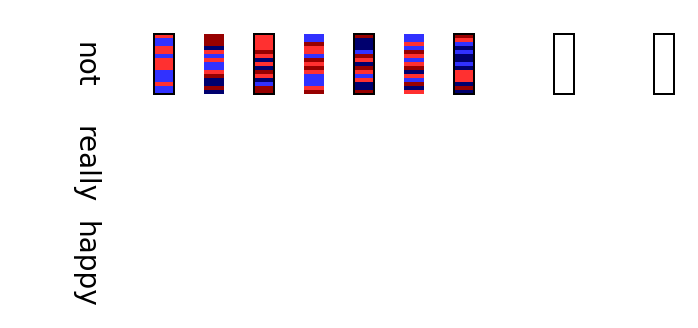

In [42]:
plot_model(plt.gca())

/Users/jeanremi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/Users/jeanremi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


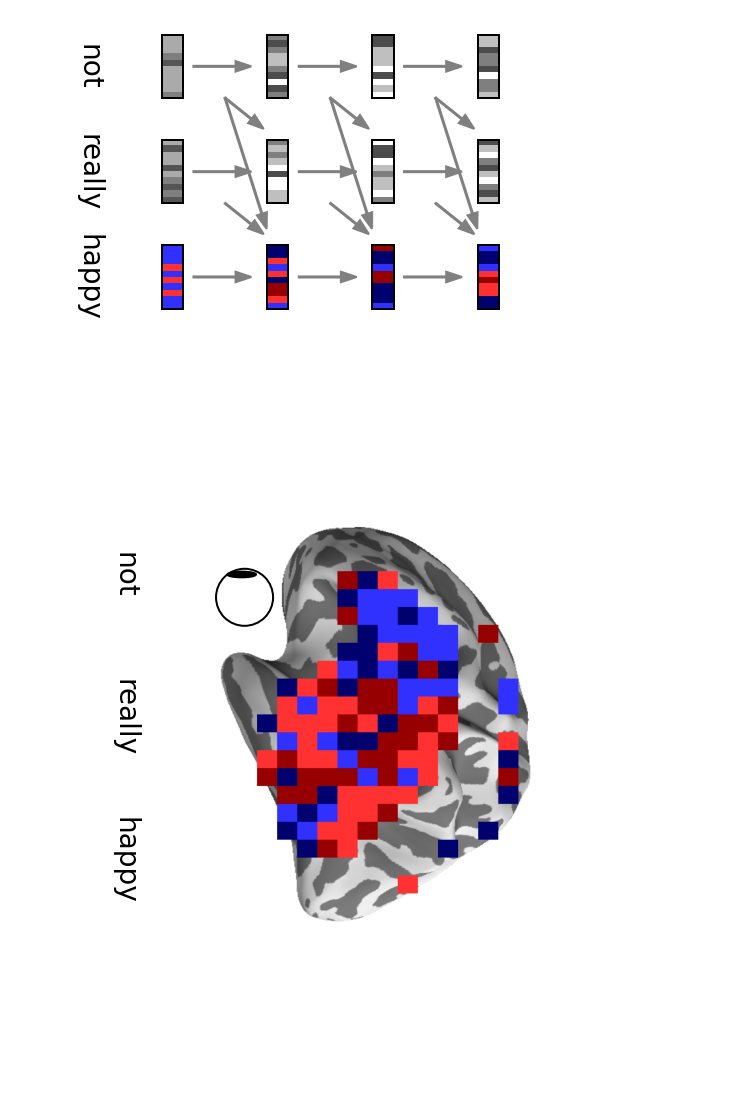

<Figure size 1008x720 with 0 Axes>

<Figure size 1008x720 with 0 Axes>

In [176]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[5.2, 9])

plot_model(ax1)
plot_brain(ax2)
fig.tight_layout()
fig.savefig('/Users/jeanremi/Desktop/hasson_hypothesis.png', facecolor='white', dpi=120)